In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from os import listdir, path
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import datetime
import random
import math

tf.__version__

'2.1.0'

### Load Infrared temperature readings from CSV files and convert them to TensorFlow Datasets

In [2]:
def load_data(data_type, files):
    data   = []
    labels = []
    random.shuffle(files)
   
    for file in files:
        with open(file) as f:
            label = path.splitext(file)[0][-1]
            labels.append(int(label)-1)
            readings = []
            for line in f:
                reading = line.strip().split(',')
                readings.append([float(i) for i in reading[0:32*24]])

            data.append(readings)
            
    features = np.array(data).reshape(-1, 24, 32)
    labels   = np.array(labels)
    dataset = tf.data.Dataset.from_tensor_slices((features, labels.astype("int32")))
    return len(data), dataset


### Extract labels from the filename and split into training, validation, and test datasets

In [3]:
files_path = defaultdict(list)
dir = '../datasets/batch_1'
for filename in listdir(dir):
    if filename.endswith('.csv'):
        digit = path.splitext(filename)[0][-1]
        files_path[digit].append(path.join(dir, filename))

train_files      = []
validation_files = []
test_files       = []

for digit in files_path:
    random.shuffle(files_path[digit])
    
    train_split = int(len(files_path[digit]) * 0.6) # 60%
    validation_split = train_split + int(len(files_path[digit]) * 0.2) # 20%

    train_files += files_path[digit][:train_split]
    validation_files += files_path[digit][train_split:validation_split]
    # remaining 20%
    test_files += files_path[digit][validation_split:]

train_length, train_data = load_data('train', train_files)
validation_length, validation_data = load_data('validation', validation_files)
test_length, test_data = load_data('test', test_files )

print('train_length={} validation_length={} test_length={}'.format(train_length, validation_length, test_length))

train_length=33 validation_length=10 test_length=14


### Display datasets as plot

In [4]:
images = []
labels = []

for d, l in train_data:
    images.append(d.numpy())
    labels.append(l.numpy())
    
class_names = {
    0: 'Person',
    1: 'Object',
    2: 'Background'
}

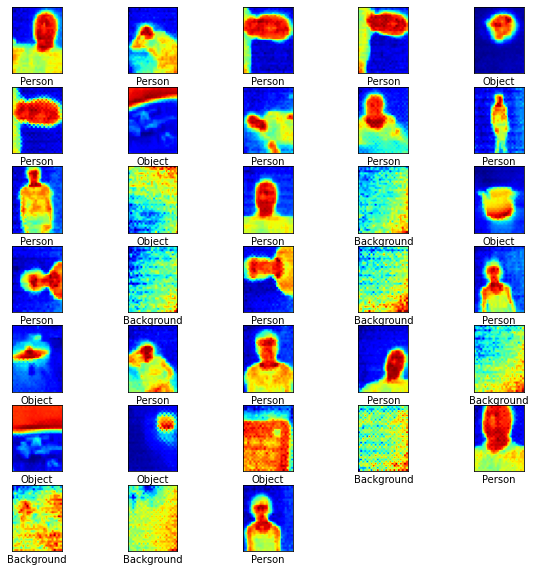

In [5]:
plt.figure(figsize=(10,10))
for i in range(len(images)):
    plt.subplot(math.ceil(len(images)/5), 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i].T, cmap=plt.cm.jet)
    plt.xlabel(class_names[labels[i]])
plt.show()

### Build a model using Keras api

In [6]:

model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(8, (3, 3), padding="same", activation="relu", input_shape=(24,32,1)),
      tf.keras.layers.Conv2D(8, (3, 3), padding="same", activation="relu"),
      tf.keras.layers.MaxPool2D((2, 2)),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Conv2D(8, (3, 3), padding="same", activation="relu"),
      tf.keras.layers.MaxPool2D((2, 2), padding="same"),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Conv2D(16, (3, 3), padding="same", activation="relu"),
      tf.keras.layers.MaxPool2D((2, 2), padding="same"),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Conv2D(16, (3, 3), padding="same", activation="relu"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64, activation="relu"),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(32, activation="relu"),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(3, activation="softmax")
  ])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 32, 8)         80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 32, 8)         584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 16, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 16, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 16, 8)         584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 8, 8)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 8, 8)           0

### Model training

In [7]:
epochs = 10
batch_size = 64
steps_per_epoch=1000

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

def reshape_function(data, label):
  reshaped_data = tf.reshape(data, [24, 32, 1])
  return reshaped_data, label

train_data = train_data.map(reshape_function)
validation_data = validation_data.map(reshape_function)

train_data = train_data.batch(batch_size).repeat()
validation_data = validation_data.batch(batch_size)

logdir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# # Uncomment the ines below if you like to see how training proceeds
# %load_ext tensorboard
# %tensorboard --logdir logdir

model.fit(
  train_data,
  epochs=epochs,
  validation_data=validation_data,
  steps_per_epoch=steps_per_epoch,
  validation_steps=int((validation_length - 1) / batch_size + 1),
  callbacks=[tensorboard_callback])

Train for 1000 steps, validate for 1 steps
Epoch 1/10
1000/1000 [==============================] - 13s 13ms/step - loss: 0.2321 - accuracy: 0.9131 - val_loss: 0.0598 - val_accuracy: 1.0000
Epoch 2/10
1000/1000 [==============================] - 12s 12ms/step - loss: 0.0847 - accuracy: 0.9712 - val_loss: 0.9438 - val_accuracy: 0.8000
Epoch 3/10
1000/1000 [==============================] - 12s 12ms/step - loss: 0.0312 - accuracy: 0.9892 - val_loss: 1.5973 - val_accuracy: 0.7000
Epoch 4/10
1000/1000 [==============================] - 12s 12ms/step - loss: 0.0193 - accuracy: 0.9935 - val_loss: 0.8756 - val_accuracy: 0.9000
Epoch 5/10
1000/1000 [==============================] - 12s 12ms/step - loss: 0.0175 - accuracy: 0.9944 - val_loss: 1.0961 - val_accuracy: 0.9000
Epoch 6/10
1000/1000 [==============================] - 13s 13ms/step - loss: 0.0116 - accuracy: 0.9963 - val_loss: 0.8621 - val_accuracy: 0.9000
Epoch 7/10
1000/1000 [==============================] - 16s 16ms/step - loss: 0.0

### Evaluate the trained model

In [8]:
test_data = test_data.map(reshape_function)
test_labels = np.zeros(test_length)

# There is no easy function to get the labels back from the tf.data.Dataset :(
# Need to iterate over dataset
idx = 0
for data, label in test_data:
    test_labels[idx] = label.numpy()
    idx += 1
    
test_data = test_data.batch(batch_size)

loss, acc = model.evaluate(test_data)
pred = np.argmax(model.predict(test_data), axis=1)

# Create a confusion matrix to see how model predicts
confusion = tf.math.confusion_matrix(labels=tf.constant(test_labels), predictions=tf.constant(pred), num_classes=3)
print(confusion)

1/1 [==============================] - 0s 7ms/step - loss: 1.0781 - accuracy: 0.9286
tf.Tensor(
[[6 0 0]
 [0 3 1]
 [0 0 4]], shape=(3, 3), dtype=int32)


### Convert Keras model to TensorFlow Lite FlatBuffer

In [9]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("model.tflite", "wb").write(tflite_model)

# Convert the model to the TensorFlow Lite format with quantization
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
# tflite_model = converter.convert()
# open("model_quantized.tflite", "wb").write(tflite_model)

81116

### Check model input details

In [10]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the TensorFlow Lite model on random input data.
input_details[0]['shape']

array([ 1, 24, 32,  1], dtype=int32)

### Convert the FlatBuffer to a C byte array to deploy to the microcontroller

In [ ]:
! xxd -i model.tflite model.tflite model_data.cpp